# Practice Case for Social Media Analysis with SPARK
### Topik Zulkarnain
***
This notebook provided sentiment analysis with spark, on this case I’ll be use twitter data contains only two columns which is text and target. The purpose of this analysis is to make model for classifying the tweets wether the tweet include in the negative sentiment or positive sentiment. Without further a do, lets just started it.

1. Data Preparation<br>
2. Data Preprocessing<br>
   2.1 Lower Casing<br>
   2.2 Punctuation Removal<br>
   2.3 Spelling Correction<br> 
   2.4 Normalization<br>
   2.5 Stopword Removal<br>
   2.6 Tokenization<br>
   2.7 Lemmatization<br>
   2.8 Stemming<br> 
3. Sentiment Analysis<br>
   3.1 Visualization<br>
   3.2 Feature Extraction<br>
   3.3 Modelling and Model Evaluation<br>

<br>
***


## 1. Data Preparation
#### Import Dataset

First thing first, I’ll import the dataset on spark. The dataset name is clean_tweet with csv format, this data contains only two columns which is text and target. <br>
•	Text : tweet data <br>
•	Target : the sentiment of tweet <br>

In [1]:
import pandas
import random

filename = "clean_tweet.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 800000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pandas.read_csv(filename, skiprows=skip)

In [2]:
df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,i dived many times for the ball managed to sav...,0
2,no it s not behaving at all i m mad why am i h...,0
3,need a hug,0
4,hey long time no see yes rains a bit only a bi...,0


I want to check the number of each sentiment,

In [3]:
df_number_of_each_sentiment = df.groupby(['target']).count()
df_number_of_each_sentiment

,text
target,
0,399665
1,398718


From the output image above, the data have a big equal number of sentiment which 800 thousand each. Next, I want to check if theres a missing values on both columns,

In [4]:
df.isnull().sum()

text      1617
target       0
dtype: int64

As from the output above, only text columns contains 3.247 missing values. There are several ways to handle missing values on data which is ignored it, drop it, or use statistical descriptive to fill it. For this case I prefer to drop missing data. Now the data has no missing values anymore, we can now proceed to make a modeling to classifying sentiment of tweet.

In [5]:
df = df.dropna()
df.shape

(798383, 2)

## 2. Text Preprocessing
These steps are needed for transferring text from human language to machine-readable format for further processing

### 2.1 Lower Casing

In [6]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'].head(5)

0    awww that s a bummer you shoulda got david car...
1    i dived many times for the ball managed to sav...
2    no it s not behaving at all i m mad why am i h...
3                                           need a hug
4    hey long time no see yes rains a bit only a bi...
Name: text, dtype: object

### 2.2 Punctuation Removal

In [7]:
df['text'] = df['text'].str.replace('[^\w\s]','')
df['text'].head(5)

0    awww that s a bummer you shoulda got david car...
1    i dived many times for the ball managed to sav...
2    no it s not behaving at all i m mad why am i h...
3                                           need a hug
4    hey long time no see yes rains a bit only a bi...
Name: text, dtype: object

### 2.3 Stopwords Removal 

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head(5)

0         awww bummer shoulda got david carr third day
1    dived many times ball managed save rest go bounds
2                                     behaving mad see
3                                             need hug
4    hey long time see yes rains bit bit lol fine t...
Name: text, dtype: object

### 2.4 Rare Words Removal

In [9]:
rare_word = pandas.Series(' '.join(df['text']).split()).value_counts()[-10:]
rare_word

forhim                  1
spgridview              1
hollywoodbound          1
distatcions             1
randalio                1
dirkie                  1
handend                 1
dort                    1
velcroshoes             1
undergraduatedegrees    1
dtype: int64

### 2.5 Spelling Correction

In [10]:
from textblob import TextBlob
df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0           www summer should got david care third day
1    dived many times ball managed save rest go bounds
2                                     behaving mad see
3                                             need hug
4    hey long time see yes rains bit bit ll fine th...
Name: text, dtype: object

### 2.6 Tokenization

In [11]:
import nltk
TextBlob(df['text'][1]).words

WordList(['dived', 'many', 'times', 'ball', 'managed', 'save', 'rest', 'go', 'bounds'])

### 2.7 Stemming 

In [12]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text'] = df['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [13]:
df['text'].head()

0        awww bummer shoulda got david carr third day
1        dive mani time ball manag save rest go bound
2                                       behav mad see
3                                            need hug
4    hey long time see ye rain bit bit lol fine thank
Name: text, dtype: object

### 2.8 Lemmatization

In [14]:
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['text'].head()

0        awww bummer shoulda got david carr third day
1        dive mani time ball manag save rest go bound
2                                       behav mad see
3                                            need hug
4    hey long time see ye rain bit bit lol fine thank
Name: text, dtype: object

## 3. Sentiment Analysis

### 3.1 Visualization
On this step, I want to take a look closer data and want to know what is the frequent word use on each sentiment by using wordcloud. From this, I can at least know what caused sentiment by look at the wordcloud

In [15]:
from wordcloud import WordCloud, STOPWORDS
positive = df[df['target'] == 1]
negative = df[df['target'] == 0]

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,120))
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 50, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [17]:
all_description_positive = "".join(positive.text.values)
all_description_negative = "".join(negative.text.values)

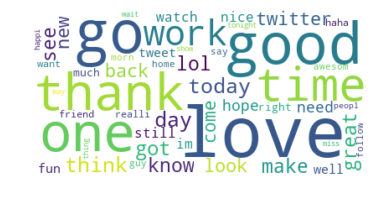

In [18]:
create_word_cloud(all_description_positive)

for positive sentiment, most often words appears can be seen in the picture above

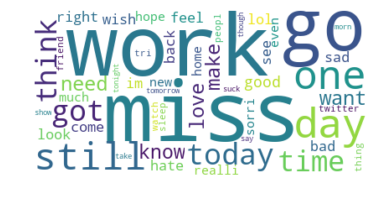

In [19]:
create_word_cloud(all_description_negative)

for negative sentiment, most often words appears can be seen in the picture above

### 3.2 Feature Extraction
On this analysis, I'll use two kind of feature extraction CountVectorizer and TF-IDF and later on we will comparing and evaluating which Feature extraction fit best for this problem

In [20]:
#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\topikz064115\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
count_vectorizer = CountVectorizer(stop_words='english')

In [22]:
tfidf = TfidfVectorizer(stop_words='english' )

In [23]:
X = df['text']
y = df['target']

In [24]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

since we have data with big entries, its safe to split data only 10% for test set and 90% for train set

In [25]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.1, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.1, random_state=0)

### 3.3 Modelling and Model Evaluation
I will comparing 2 model which is Logistic Regression both with CountVectorizer and TF-IDF and Naive Bayes with CountVectorizer and TF-IDF also. For deciding which model and which feature extraction is the best, I'll evaluate model using recall, precision, and F1 Score 

### Using Logistic Regression

In [26]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

In [27]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

In [28]:
# using count vectorizer
print("______________ Countvectorizer ______________")

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 80.11% & 76.67%
Precision train & test  : 80.11% & 76.67%
F1 Score train & test   : 80.11% & 76.67%


In [29]:
# using count vectorizer
print("______________ TF-IDF ______________")


Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 79.24% & 76.83%
Precision train & test  : 79.24% & 76.83%
F1 Score train & test   : 79.24% & 76.67%


### Using Naive Bayes

In [30]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [31]:
# TFIDFVectorizer
#from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

In [32]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")


NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 78.91% & 75.87%
Precision train & test  : 78.91% & 75.87%
F1 Score train & test   : 78.91% & 75.87%


In [33]:
# using count vectorizer
print("______________ TF-IDF ______________")


NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 78.94% & 75.18%
Precision train & test  : 78.94% & 75.18%
F1 Score train & test   : 78.94% & 75.87%


## Conclusion
Base on the result of two model with two feature extraction, I can conclude that the best model for classifying sentiment of tweet is Logistic Regression + CountVectorizer with Recall <br>
Recall train & test     : 80.11% & 76.67%<br>
Precision train & test  : 80.11% & 76.67%<br>
F1 Score train & test   : 80.11% & 76.67%<br>